In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. 'monthly-us-auto-registration-tho.csv'

In [2]:
df_auto_reg = pd.read_csv('monthly-us-auto-registration-tho.csv', delimiter=';')

In [3]:
df_auto_reg.head(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
0,1947-01,209
1,1947-02,214


In [4]:
df_auto_reg.tail(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
262,1968-11,757
263,1968-12,977


In [5]:
df_auto_reg.columns = ['Month', 'Registrations']

In [6]:
df_auto_reg.head()

,Month,Registrations
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


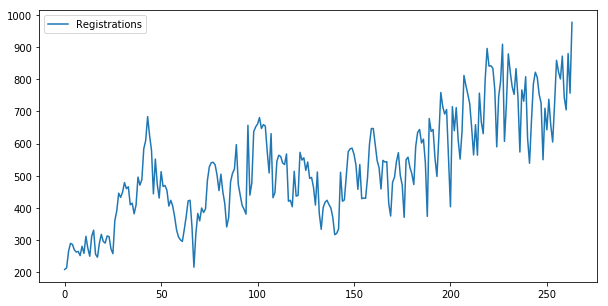

In [7]:
fig = df_auto_reg.plot(figsize=(10,5))

Имеется явный тренд, сезонность тяжело понять

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
test_stationarity(df_auto_reg['Registrations'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Ряд нестационарен, требуются преобразования.

Для начала нормализуем дисперсию.

In [11]:
from scipy.stats import boxcox

In [12]:
df_auto_reg['Registrations_box'] = boxcox(df_auto_reg['Registrations'])[0]

In [13]:
test_stationarity(df_auto_reg['Registrations_box'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.548473
p-value                          0.509411
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Попробуем определить сезонность

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
result = seasonal_decompose(df_auto_reg['Registrations_box'], freq=12)

<Figure size 1152x576 with 0 Axes>

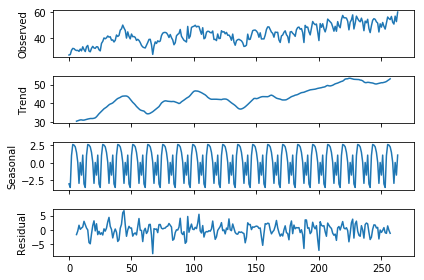

In [16]:
plt.figure(figsize=(16,8))
fig = result.plot()

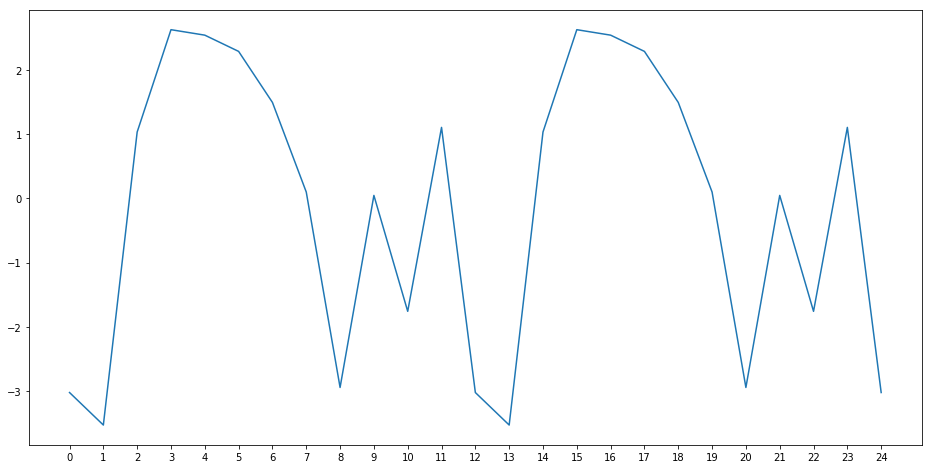

In [17]:
plt.figure(figsize=(16,8))
fig = result.seasonal[:25].plot()
tics = plt.xticks(range(25))

Похоже есть сезонность с периодом в 12 месяцев.

Возьмем сезонную разницу

In [18]:
df_auto_reg['Registrations_box_season'] = df_auto_reg['Registrations_box'].diff(12)

In [19]:
test_stationarity(df_auto_reg['Registrations_box_season'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -4.156235
p-value                          0.000781
#Lags Used                      12.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


Т.к. p-value < 0.05, то мы отвергаем гипотезу $H_0$ и принимаем альтернативную, что ряд временной стационарен. Однако прежде, чем окончательно отвергнуть гипотезу о нестационарности ряда необходимо посмотреть на коррелограммы.

In [20]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [21]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


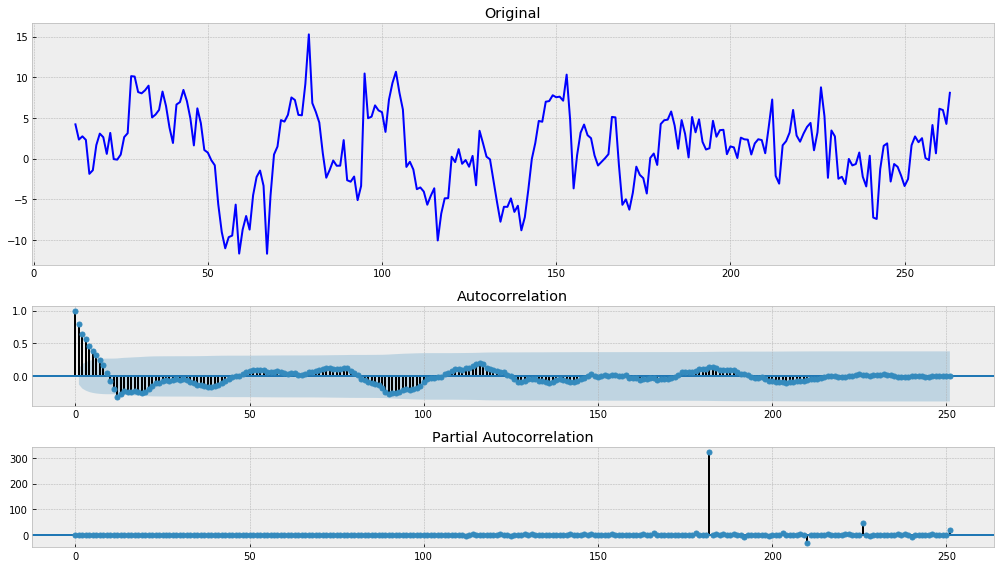

In [22]:
tsplot(df_auto_reg['Registrations_box_season'].dropna())

Ряд еще не стационарен. Возьмем первые разности.

In [25]:
df_auto_reg['Registrations_box_season_diff_1'] = df_auto_reg['Registrations_box_season'].diff()

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


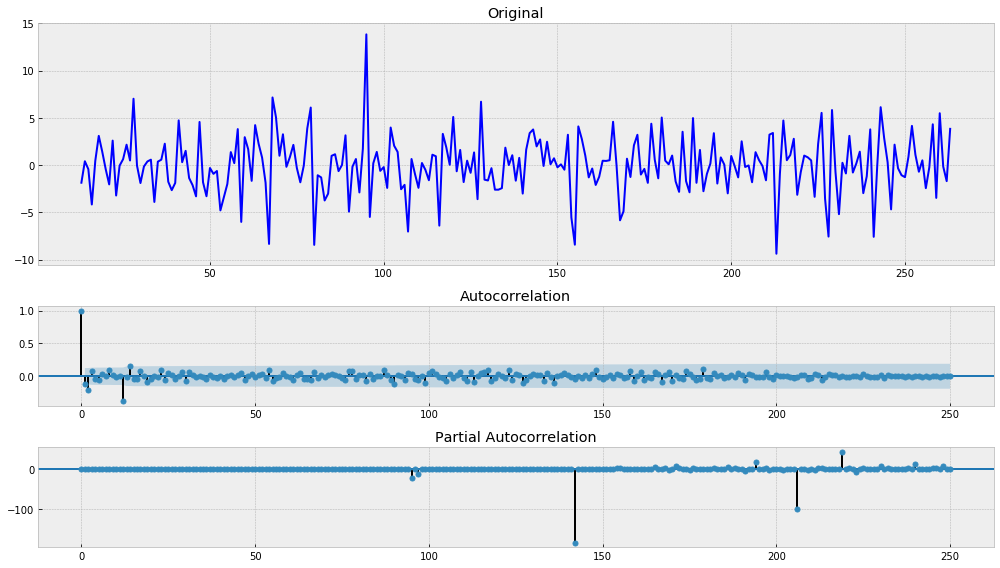

In [26]:
tsplot(df_auto_reg['Registrations_box_season_diff_1'].dropna())

In [27]:
test_stationarity(df_auto_reg['Registrations_box_season_diff_1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.604213e+00
p-value                        6.618944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


Теперь можно отвергунть гипотезу о нестационарности ряда и принять гипотезу о стационарности.

### 2. 'weekly-closings-of-the-dowjones-.csv'

In [29]:
df_dow_jones = pd.read_csv('weekly-closings-of-the-dowjones-.csv')

In [30]:
df_dow_jones.head(2)

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
0,1971-W27,890.19
1,1971-W28,901.80


In [31]:
df_dow_jones.tail(2)

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
160,1974-W31,784.57
161,1974-W32,752.58


In [32]:
df_dow_jones.columns = ['Week', 'Closing']

In [33]:
df_dow_jones.head(1)

,Week,Closing
0,1971-W27,890.19


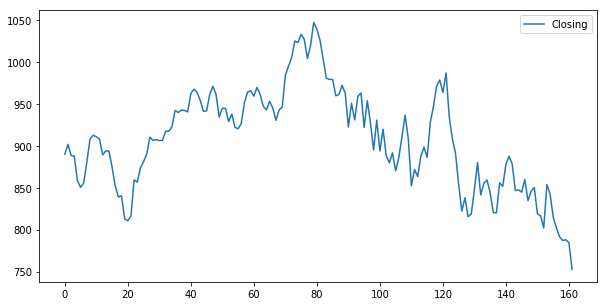

In [34]:
fig = df_dow_jones.plot(figsize=(10,5))

In [35]:
test_stationarity(df_dow_jones['Closing'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


Ряд нестационарен, требуются преобразования.

Для начала нормализуем дисперсию.

In [36]:
df_dow_jones['Closing_box'] = boxcox(df_dow_jones['Closing'])[0]

In [37]:
test_stationarity(df_dow_jones['Closing_box'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.327773
p-value                          0.616372
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


Попробуем определить сезонность

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [39]:
result = seasonal_decompose(df_dow_jones['Closing_box'], freq=52)

<Figure size 1152x576 with 0 Axes>

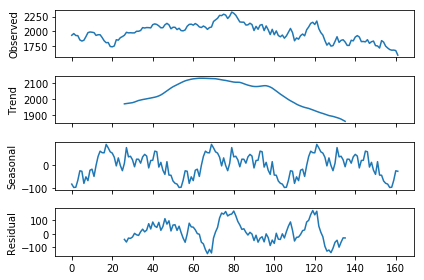

In [40]:
plt.figure(figsize=(16,8))
fig = result.plot()

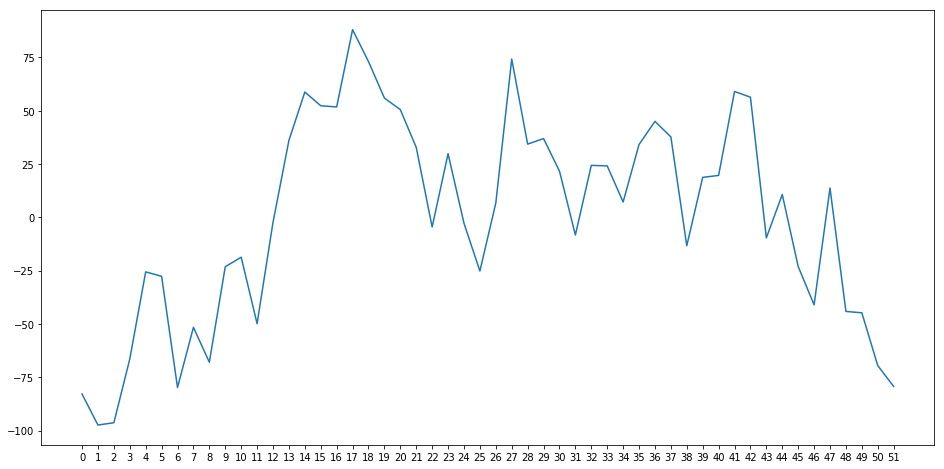

In [41]:
plt.figure(figsize=(16,8))
fig = result.seasonal[:52].plot()
tics = plt.xticks(range(52))

Похоже есть сезонность с периодом в 52 недели.

Возьмем сезонную разницу

In [42]:
df_dow_jones.head(1)

,Week,Closing,Closing_box
0,1971-W27,890.19,1935.977038


In [43]:
df_dow_jones['Closing_box_season'] = df_dow_jones['Closing_box'].diff(52)

In [44]:
test_stationarity(df_dow_jones['Closing_box_season'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -1.224496
p-value                          0.662970
#Lags Used                       0.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


Мы пока не можем отвернуть гипотезу о нестационарности ряда, т.к. p-value > 0.05

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


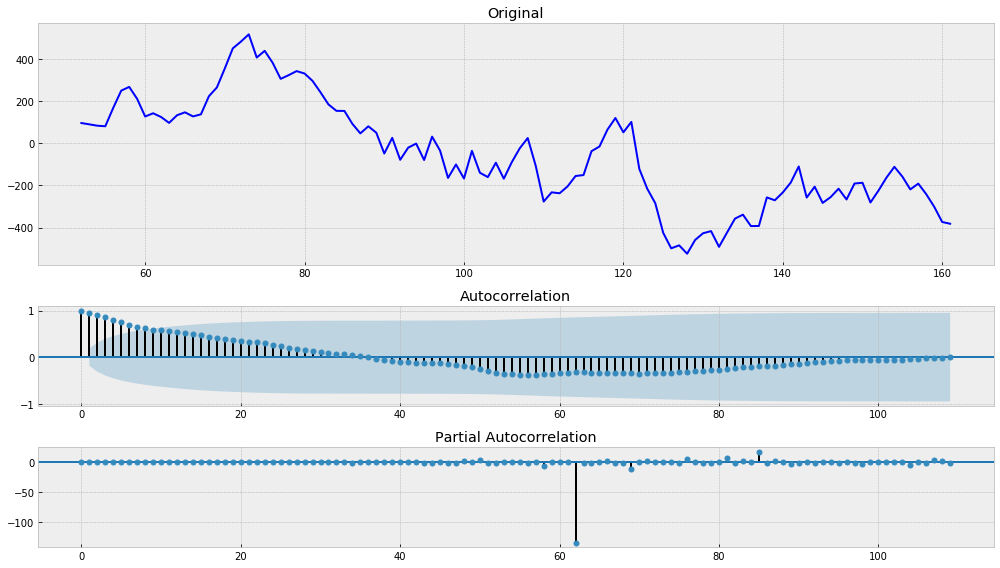

In [46]:
tsplot(df_dow_jones['Closing_box_season'].dropna())

Возьмем первые разности.

In [47]:
df_dow_jones['Closing_box_season_diff_1'] = df_dow_jones['Closing_box_season'].diff()

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


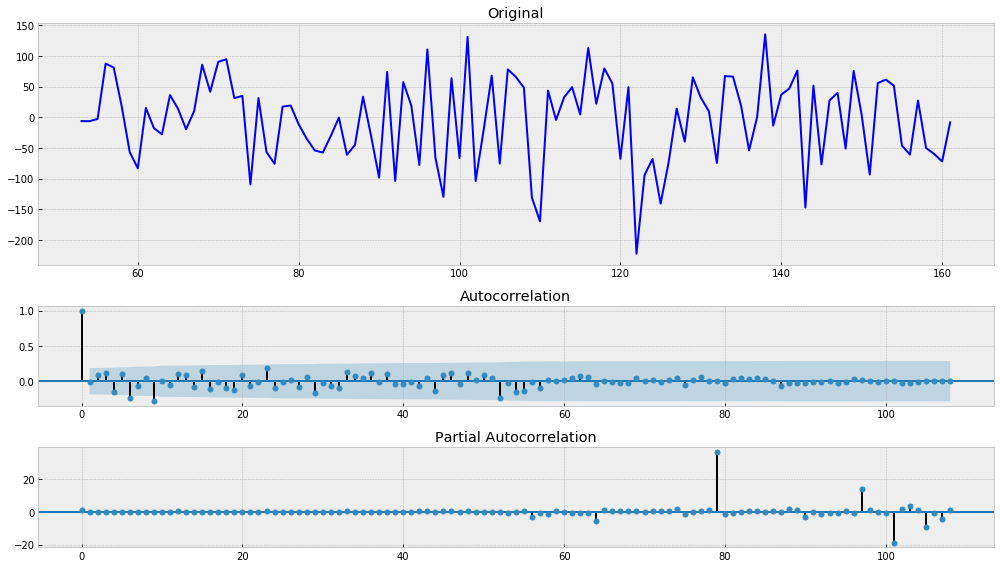

In [48]:
tsplot(df_dow_jones['Closing_box_season_diff_1'].dropna())

In [49]:
test_stationarity(df_dow_jones['Closing_box_season_diff_1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -4.862723
p-value                          0.000041
#Lags Used                       5.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


Теперь можно отвергунть гипотезу о нестационарности ряда и принять гипотезу о стационарности.